In [1]:
from spectral import open_image, msam
import pysptools.eea as eea #for extracting endmembers
from xarr_helpers import extract_from_NEON
import geopandas as gpd
import fiona
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np

import pysptools.util as util
import pysptools.eea as eea
import pysptools.abundance_maps as amp
from pysptools.classification import SAM
from earthpy.spatial import bytescale
# from shapely.geometry import mapfor xarr_VNIR, x_vnir, y_vnir, xarr_SWIR, x_swir, y_swir in zip(xarr_VNIR_ls, x_vnir_ls, y_vnir_ls, xarr_SWIR_ls, x_swir_ls, y_swir_ls):ping, box

D:\Ian\Applications\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Ian\Applications\Anaconda\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Import raw data
dtype = "VNIR"
bin_path = '../headwall_data/Radiance/' + dtype + '_CUSouth/headwall_CUS_block4000_' + dtype.lower() + '_rad_glt_cor.hdr'
data, header = util.load_ENVI_file(bin_path)
wavelengths = np.asarray(header['wavelength'])
hsi_cube = np.nan_to_num((data)) # get rid of nans 
# data is mxnx(wavelengths) raw pixel values.

(270,)


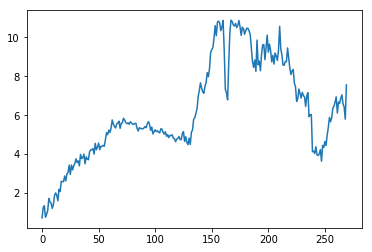

In [5]:
# get endmembers using hardcoded position vec
def get_vec(data, pos):
    return data[pos[0],pos[1],:]

em_pixel = (150, 250) # pos of a pixel on the tennis court
em = get_vec(hsi_cube, em_pixel)

print(em.shape)
plt.plot(em)

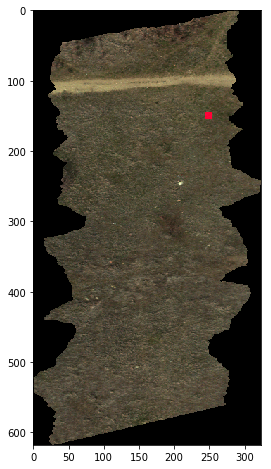

In [36]:
def show_rgb(input_img, focus_pixel = tuple()):
    # Add 10x10 marker where em pixel is, plot in RGB
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])
    ax1 = plt.subplot(gs[1])
    rgb_img = bytescale(input_img[:,:,[135, 72, 41]]) # 135, 72, 41 correspond roughly to R G B wavelengths
    
    if (focus_pixel != ()):
        # This is a suboptimal solution. Also, no edge case safety measures.
        rgb_img[(focus_pixel[0]-5):(focus_pixel[0]+5),(focus_pixel[1]-5):(focus_pixel[1]+5),0] = 255 # red channel maxed
        rgb_img[(focus_pixel[0]-5):(focus_pixel[0]+5),(focus_pixel[1]-5):(focus_pixel[1]+5),1:2] = 2 # blue, green channel minned
    
    ax1.imshow(rgb_img)

show_rgb(hsi_cube, em_pixel)

D:\Ian\Applications\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


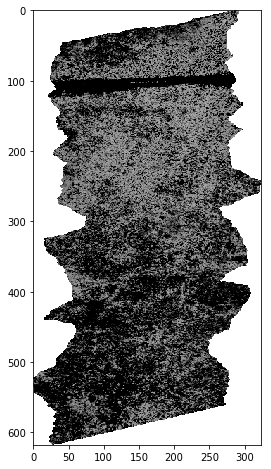

In [34]:
# Manually compute dot product to compute sam
# https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
def angle_between(v1, v2):
    # returns angle in radians
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

rad_map = np.zeros((hsi_cube.shape[0], hsi_cube.shape[1]))
for row in range(hsi_cube.shape[0]): # list comprehension would speed this up
    for col in range(hsi_cube.shape[1]):
        theta = np.clip(np.nan_to_num(angle_between(hsi_cube[row,col,:], em)), 0, 0.2)
        rad_map[row,col] = theta
        
scaled_map = bytescale(rad_map)
fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])
ax1 = plt.subplot(gs[1])
tmp = ax1.imshow(scaled_map, cmap = "gray_r")


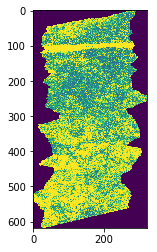

In [9]:
scaled_map = bytescale(rad_map)
plt.imshow(scaled_map)
plt.show()
